In [32]:
include("dependencies.jl")
include("brute_force_new.jl")
include("boundary_evolution.jl")
push!(LOAD_PATH, ".")
using BP, Ising2D
using Random, Plots
function parity_tensor(index_arr, parity)
    num = length(index_arr)
    tens = ITensor(index_arr)
    for i in 0:(2^num - 1)
        bits = digits(i, base=2, pad=num) 
        if sum(bits) % 2 == parity
            inds_tuple = (index_arr[j] => bits[j] + 1 for j in 1:num)
            tens[inds_tuple...] = 1.0        
        end 
    end
    return tens 
end 

function dumbcontract(tensors)
    ans = ITensor(1)
    for tt in tensors 
        ans = ans * tt 
    end
    return scalar(ans )
end 


dumbcontract (generic function with 1 method)

In [2]:
## x1   x2     x3   ..          xn -> infer 
##.   c1    c2            cn-1 -> given 

In [ ]:
N = 10 
function rep_code(syndrome)
    N = length(syndrome) + 1 
    lefts = [Index(2, "cL$i") for i in 1:N-1]
    rights = [Index(2, "cR$i") for i in 1:N-1]
    datas = [Index(2, "x$i") for i in 1:N]
    data_tensors = []
    syn_tensors = []
    ## data data_tensors
    push!(data_tensors,delta(datas[1],lefts[1]))
    for i = 2:N-1 
        tensor = delta(datas[i],rights[i-1],lefts[i])
        push!(data_tensors,tensor)
    end 
    push!(data_tensors,delta(datas[N],rights[N-1]))
    ## check tensors 
    for i = 1:N-1
        tensor = parity_tensor([lefts[i],rights[i]],syndrome[i])
        push!(syn_tensors,tensor)
    end 
    return data_tensors, syn_tensors, datas
end 


function bit_to_onehot(x)
    if x == 0
        return [1, 0]
    elseif x == 1
        return [0, 1]
    elseif x == -1
        return [1, 1]
    else
        error("Input must be -1, 0, or 1")
    end
end


function get_marginal_data_tensors(data_tensors,data_indices,data_inputs)
    N = length(data_tensors)
    marginalized = []
    for i = 1 : N 
        tens = data_tensors[i] *  ITensor(bit_to_onehot(data_inputs[i]),data_indices[i])
        push!(marginalized,tens)
    end 
    return marginalized
end 

function replace_at_index(arr, index, new_val)
    arr_copy = deepcopy(arr)       # Step 1: copy original array
    arr_copy[index] = new_val  # Step 2: replace value at index
    return arr_copy            # Step 3: return new array with update
end

function sample_bit(p0)
    return rand() < p0 ? 0 : 1
end


sample_bit (generic function with 1 method)

In [ ]:
function get_marginal(tensors,adj_mat,messages,index)
    nbrs = BP.get_nbrs(adj_mat, index)
    Z_local = tensors[index] 
    for nbr in nbrs
        Z_local *= messages[nbr,index] 
    end
    return Z_local
end 

function run_rep_code_sim(N, p, num_samples)
    logical_error_count = 0
    for _ in 1:num_samples
        # Sample errors iid with probability p
        errors_true = [sample_bit(1-p) for _ in 1:N]
        # Compute syndrome
        syndrome = [mod(errors_true[i] + errors_true[i+1], 2) for i in 1:N-1]
        # Decode using the code above
        data_tensors, syn_tensors, data_indices = rep_code(syndrome)
        errors = Int.(-1 .* ones(N))
        for i = 1:N
            tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, replace_at_index(errors, i, 0)), syn_tensors)
            adj_mat, edges, links = BP.get_adj_mat(tensors)
            messages = BP.get_messages(tensors,edges,links) 
            messages = BP.message_passing(tensors,messages,edges,links,adj_mat;α=1.0,max_iters=500,diagnose=false,normalise=true)
            probs = get_marginal(vcat(data_tensors,syn_tensors),adj_mat,messages,i)
            ix = inds(probs)[1]
            probs = [real(probs[ix=>n]) for n in 1:dim(ix)]
            probs ./= sum(probs) 
            error_i = sample_bit(probs[1])
            errors[i] = error_i
        end
        # Check if decoded errors match true errors (up to global flip)
        if sum(errors) > N/2 ## if so, decoder failed
            continue
        end
        logical_error_count += (sum(errors .!= errors_true) > 0)
    end
    return logical_error_count / num_samples
end

run_rep_code_sim (generic function with 1 method)

5
10


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:59

20


Progress: 100%|█████████████████████████████████████████| Time: 0:13:09


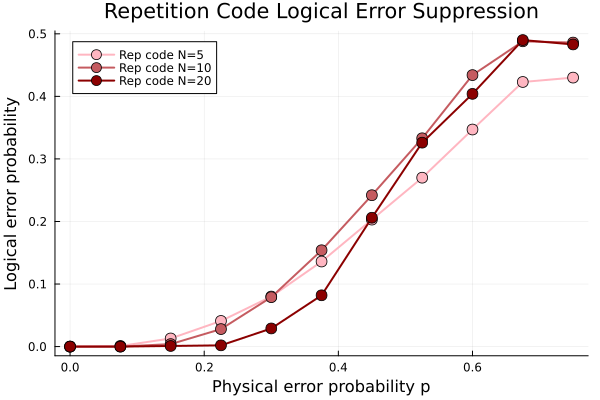

In [72]:
N_Ar = [5,10,20]
num_samples = 1000
ps = 0:0.075:0.75
colors = Plots.cgrad(:reds, length(N_Ar)).colors  # Use a red gradient

plt = plot()

@showprogress for (i, N) in enumerate(N_Ar)
    println(N)
    logical_probs = [run_rep_code_sim(N, p, num_samples) for p in ps]
    plot!(plt, ps, logical_probs;
          label="Rep code N=$N",
          lw=2,
          color=colors[i],
          marker=:circle,
          markersize=6,
          linestyle=:solid)
end

xlabel!("Physical error probability p")
ylabel!("Logical error probability")
title!("Repetition Code Logical Error Suppression")
